## Practice : Detector followed by Tracker
1. Input images from wiiplay.mp4 for level 52 (frame number:19400~20000).
2. Use <i>cv2.HOGDescriptor()</i> to <b>detect</b> pedestrian on the first frame. (frame number=19400)
3. Use <i>cv2.TrackerMedianFlow_create()</i> to <b>track</b> the detected pedestrian on subsequent frames. (marked as red rectangle)
4. Insted of detection followed by tracking, try to detect pedestrian on each frames without tracking. (marked as green rectangle)
5. Observe the results and compare the difference between these two approaches. 
6. Show your output images.
7. Upload your Jupyter code file (*.ipynb)

In [1]:
import cv2
import numpy as np


def passfunc(pos):
    pass



cap = cv2.VideoCapture('WiiPlay.mp4')

time_length = 210
fps=30
frame_seq = 19400
out_size = (480, 270)

cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq);

if not cap.isOpened():
    raise IOError("Cannot open the video file")
ret, frame = cap.read()

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
locations, weights = hog.detectMultiScale(frame, hitThreshold = 0.5, winStride=(3,3), finalThreshold = 1)


for loc in locations:
    cv2.rectangle(frame, (loc[0], loc[1]),(loc[0]+loc[2], loc[1]+loc[3]), (0, 0, 255), 3)
    
cv2.putText(frame, "First frame", (0, 80), cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),3)
cv2.imshow('MedianFlow tracker', frame) 
cv2.waitKey(20)
#cv2.destroyAllWindows()
q = 0

while True:
    q+=1
    if q == 600:
        break
    #cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame = cap.read()

    locations, weights = hog.detectMultiScale(frame, hitThreshold = 0.5, winStride=(3,3), finalThreshold = 1)
    for loc in locations:
        cv2.rectangle(frame, (loc[0], loc[1]),(loc[0]+loc[2], loc[1]+loc[3]), (0, 255, 0), 3)

    cv2.imshow("MedianFlow tracker", frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

### example output
#### 執行時會蠻卡的
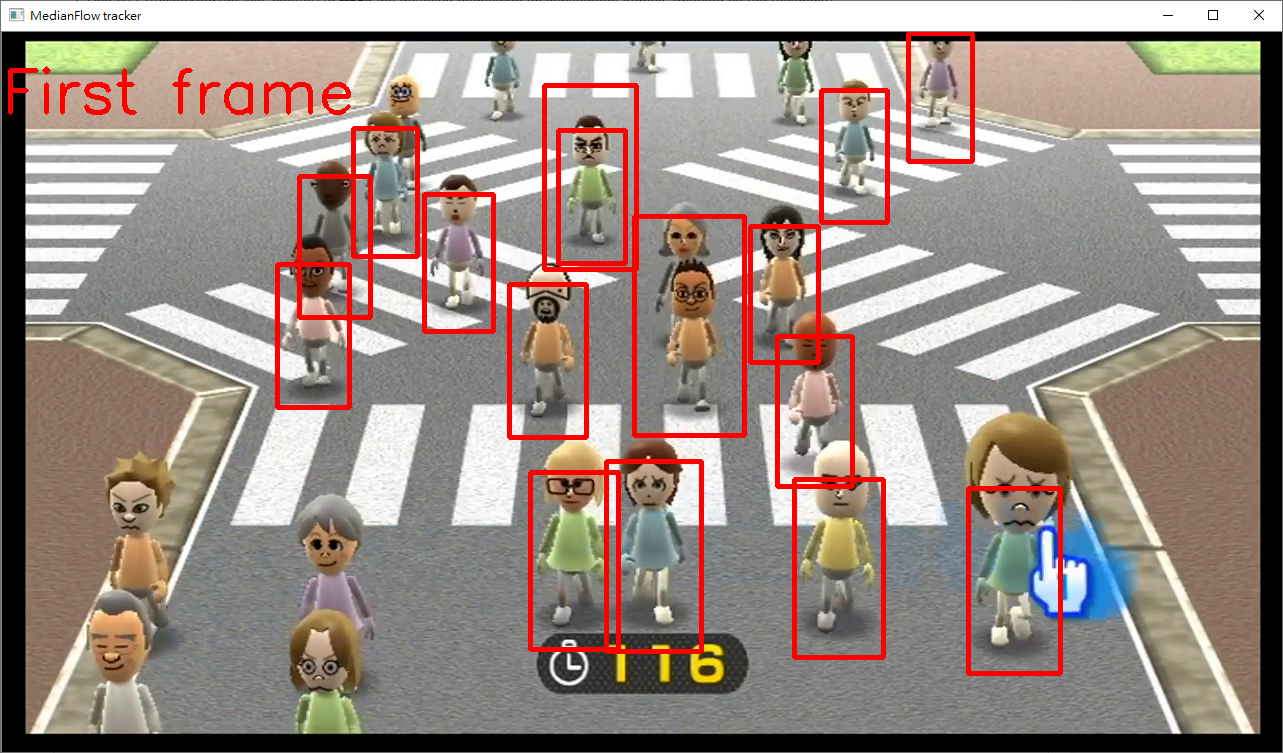
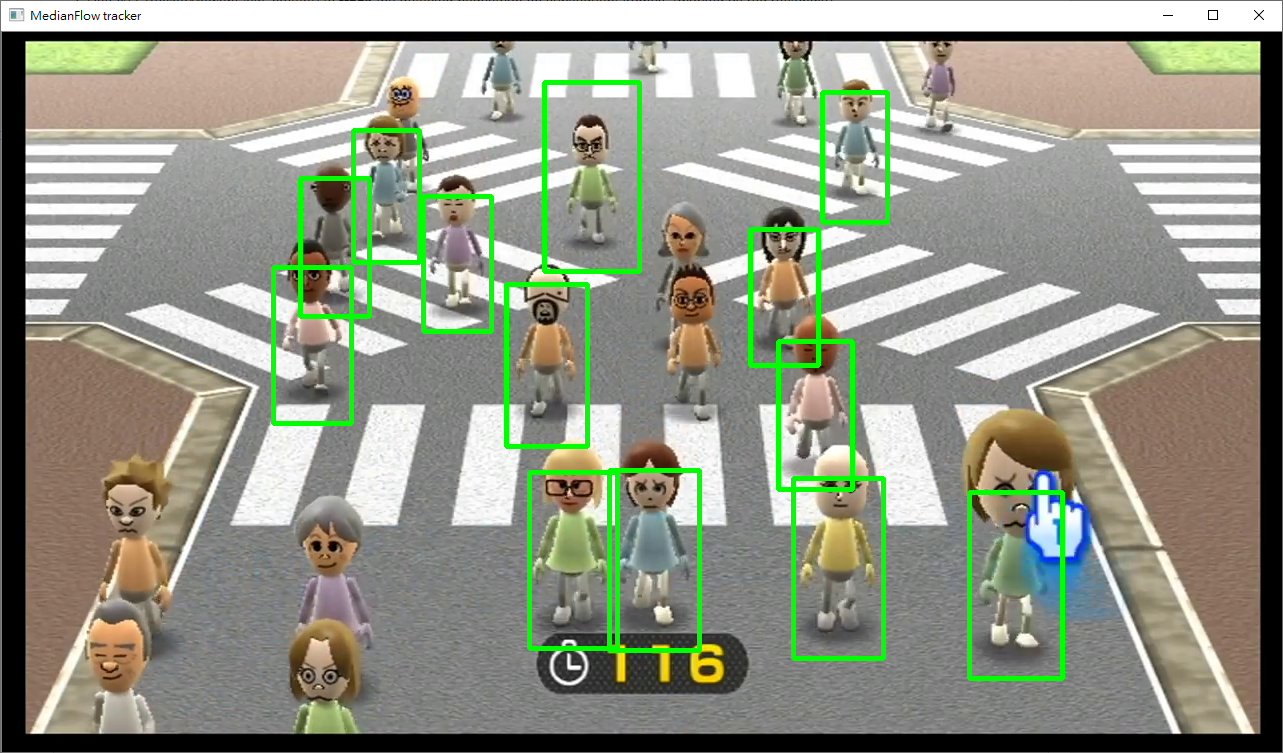

In [2]:
#solve wiiplay find mii game_2 : "find_two_look_alike"
#requires haarcascade_frontalface_default.xml
import cv2
import numpy as np

scaling_factor = 1
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 2180

# Using HOG for pedestrian detection
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Using haarcascade for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
final_template = None
max_similarity = -1
templates = list()

while True:
    frame_seq += 1
    if frame_seq > 2380:
        frame_seq = 2180
    cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame0 = cap.read()
    if not status_cap:
        break
    frame = cv2.resize(frame0, None, fx=0.75, fy=0.75)
    final_frame = frame.copy()
    
    # Draw pedestrian
    locations, weights = hog.detectMultiScale(frame, finalThreshold = 2)
    for loc in locations:   
        cv2.rectangle(final_frame, (loc[0], loc[1]-50),(loc[0]+loc[2], loc[1]+loc[3]), (0, 255, 0), 3)
    
    # Face detection
    face_rects = face_cascade.detectMultiScale(frame, scaleFactor=1.5, minNeighbors=1)
    # Draw face (strict criteria) in dark blue and append face templates
    for (x,y,w,h) in face_rects:
        hsv_face = cv2.cvtColor(frame[y+5:y-10+h, x+5:x-10+w], cv2.COLOR_BGR2HSV)
        # Check hsv of detected faces, if pass then put into templates list
        if (np.mean(hsv_face[:,:,0])>=0 and np.mean(hsv_face[:,:,0])<=35):
            if (np.mean(hsv_face[:,:,1])>=50 and np.mean(hsv_face[:,:,1])<=200):
                if (np.mean(hsv_face[:,:,2])>=60 and np.mean(hsv_face[:,:,2])<=235): 
                    templates.append(frame[y+5:y-10+h, x+5:x-10+w])
                    cv2.rectangle(final_frame, (x-5,y-5), (x+w+5,y+h+5), (255,0,0), 3)
    # Draw face (weak criteria) in light blue
    face_rects = face_cascade.detectMultiScale(frame, scaleFactor=1.05, minNeighbors=3)
    for (x,y,w,h) in face_rects:
        cv2.rectangle(final_frame, (x-5,y-5), (x+w+5,y+h+5), (255,128,0), 3)

        
    index = 0
    for temp in templates:
        result = cv2.matchTemplate(frame, temp, cv2.TM_CCOEFF_NORMED)
        result = cv2.normalize(result, None, 0, 1, cv2.NORM_MINMAX)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
        # Highest similarity template is put to final_template
        if (maxVal >= max_similarity) and maxVal > 0.99:
            final_template = temp.copy()
            templates[index] = temp
            index+=1
    # Only keep first 3 templates in front of the list (top 3 highest similarity)
    del templates[3:]
    
    # Draw similar faces using final_template template matching
    if (templates):
        result = cv2.matchTemplate(frame, final_template, cv2.TM_CCOEFF_NORMED)
        result = cv2.normalize(result, None, 0, 1, cv2.NORM_MINMAX)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
        result2 = np.reshape(result, result.shape[0]*result.shape[1])
        sort = np.argsort(result2)[::-1]
        (y1, x1) = np.unravel_index(sort[0], result.shape) # best match
        for i in range (len(sort)):
            (y, x) = np.unravel_index(sort[i], result.shape)
            if (abs(y-y1)>10 and abs(x-x1)>10): # if position of second best match is 25 pxs away (no overlapping)
                (y2, x2) = np.unravel_index(sort[i], result.shape) # second best match
                break
        cv2.rectangle(final_frame, (x1-5, y1-5), (x1 + int(w)-5, y1 + int(h)-5),(0, 0, 255), 3)
        cv2.rectangle(final_frame, (x2-5, y2-5), (x2 + int(w)-5, y2 + int(h)-5),(0, 0, 255), 3)
    
    # Additional show current template being used to find similar faces
    if (templates): 
        final_template = cv2.resize(final_template, (256, 256), fx=1, fy=1)
        cv2.imshow('Looking for', final_template)
    cv2.imshow("find_two_look_alike", final_frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release()
cv2.destroyAllWindows()
'''reminder: requires haarcascade_frontalface_default.xml'''

'reminder: requires haarcascade_frontalface_default.xml'